In [2]:
!pip install jsonlines


In [3]:
from fastai.text import *
import jsonlines
import pandas as pd

In [5]:
f = jsonlines.open('/content/drive/My Drive/data/train.jsonl',)
data=[]
labels=[]
is_valid=[]
with jsonlines.open('/content/drive/My Drive/data/train.jsonl') as reader:
    for obj in reader:
        data.append(obj['text'])
        labels.append(obj['label'])
        is_valid.append(False)



In [6]:
df = DataFrame()

df["labels"]=labels
df["text"]=data
#df["is_valid"]=is_valid

df

,labels,text
0,0,its their character not their color that matters
1,0,don't be afraid to love again everyone is not ...
2,0,putting bows on your pet
3,0,i love everything and everybody! except for sq...
4,0,"everybody loves chocolate chip cookies, even h..."
...,...,...
8495,1,nobody wants to hang auschwitz me
8496,1,when god grants you a child after 20 years of ...
8497,1,gays on social media: equality! body positivit...
8498,1,having a bad day? you could be a siamese twin ...


In [5]:
df.to_csv("/content/drive/My Drive/data/texts.csv", index=False)


In [7]:
path="/content/drive/My Drive/data/"

data_lm = TextDataBunch.from_csv(path, 'texts.csv')

In [7]:
data_lm.save()

In [8]:
data = load_data(path)

In [9]:
data = TextClasDataBunch.from_csv(path, "texts.csv")

In [10]:
data.show_batch()

text,target
"xxbos housing , free gas , free xxunk , free healthcare and free education for my wives and children . to show xxunk for your xxunk , i 'll xxunk your 12 year old daughters , blow up your trains , planes and buses and preach hate through a xxunk xxunk in your local city and town xxunk with the purpose of turning your generous country into the same shithole",1
"xxbos "" nobody is trying to take your guns ! "" "" we only want to make you xxunk them , xxunk xxunk , ban xxunk guns , limit magazine xxunk , xxunk carrying them , ban or limit ammo , make other xxunk laws , and , if we catch you violating any of these made - up rules , throw you in prison xxrep 4 . at which",0
"xxbos if a phobia is a fear , how can i be "" homophobic "" or transphobic "" ? who xxunk a man in a dress ? ! why would i fear a man who takes it up the ass by another man ? xxunk , yes definitely . fear ? no way . the only fear i have is the xxunk of what society will look like if these",1
xxbos president trump accused of sexual assault right before the election xxunk xxunk accused sexual xxunk right before the election right before getting voted in by the senate xxunk moore accused of sexual assault right before senate election in alabama brett kavanaugh accused of sexual assault right before getting voted in by the senate still convinced that the xxunk are telling the truth ? xxunk e xxunk monday at xxunk,0
xxbos xxunk you killed me so the jew could control your media so the jews could control your banks so the jews control you money so the jews could control your government so your children could die for israel so foreigners could destroy your cities so foreigners could run your civil and public services so you become a prisoner in your own homes so your people and race are lost,1


In [11]:
data.vocab.itos[0:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'you']

In [12]:
data.train_ds[0][0]

Text [   2   16    9   70  173   15  101   62  129   31   62   30   26  394  230   88 1451]

In [13]:
data = (
    TextList.from_csv(path, "texts.csv", cols="text")
    .split_by_rand_pct(valid_pct = 0.2)
    .label_from_df(cols=0)
    .databunch()
)

In [14]:
data

TextClasDataBunch;

Train: LabelList (6800 items)
x: TextList
xxbos its their character not their color that matters,xxbos do n't be afraid to love again everyone is not like your ex,xxbos i love everything and everybody ! except for xxunk i hate xxunk,xxbos everybody loves chocolate chip cookies , even hitler,xxbos go sports ! do the thing ! win the points !
y: CategoryList
0,0,0,0,0
Path: /content/drive/My Drive/data;

Valid: LabelList (1700 items)
x: TextList
xxbos did you know that the chinese eat dogs disgusting savages,xxbos xxunk xxunk xxunk 100,xxbos happy pride month let 's go beat up lesbians,xxbos xxunk elected muslim u.s . rep . rashida tlaib " because we 're gon na go in there and we 're gon na impeach the xxunk . ' ",xxbos when you stuff your jewish chicken before you give it a good xxunk
y: CategoryList
0,1,0,0,0
Path: /content/drive/My Drive/data;

Test: None

In [15]:
bs=48

In [16]:
import pandas as pd
full = pd.read_csv("/content/drive/My Drive/data/texts.csv")
del full["labels"]
full.to_csv("/content/drive/My Drive/data/only_text.csv", index=False)


In [17]:
data_lm = (TextList.from_csv(path="/content/drive/My Drive/data/", csv_name="only_text.csv")
           #Inputs: all the text files in path
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

In [18]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [19]:
data_lm.show_batch()

idx,text
0,"bad for your health i know 5 million people that had tattoos and they all died xxbos how long can i run ? till the xxunk xxunk xxbos what is he hiding ? we need to see his tax returns ! let me stop you right there hillary you deleted 30,000 emails , used bleach bit on hard drives , then destroyed phones with hammers you have no right to"
1,"shot up a school media coverage : 2 days xxbos nothing says "" pull me over "" like some red xxunk cup xxunk lights ! xxbos xxunk with my xxunk xxbos hillary is n't in jail , the wall is n't built , isis has n't been defeated & obamacare is still in place but trump gave himself a $ xxunk million tax cut and that is important to me"
2,and xxunk of living in a big city . xxunk xxunk london xxunk xxunk : over 13 million people no islamic terrorism xxbos animals enjoy xxunk xxunk too xxbos when nobody knew who you were until you got on your xxunk xxbos xxunk little xxunk in the whole wide world xxbos xxunk into your xxunk room xxunk his sack xxbos black chicks even the white ones are ugly xxbos grandma
3,"pissed me off wanna kill her ? there u go xxunk dat xxunk xxbos man getting arrested by the xxunk xxunk xxbos what ! no i am not asian xxbos obama voters xxbos after xxunk that home xxunk meal xxbos xxunk be like when you coming in ? xxbos do n't know how to deal with black people but i guess i 'll take a shot at it xxbos """
4,", men are scum but you still go xxunk xxunk for cum xxbos removes polish with chemicals nobody bats an eye removes polish with chemicals everybody loses his shit xxbos joke time ... 3 bomb xxunk walk into a bar xxbos this is what happens when you actually go fuck yourself xxbos some noise "" and she start screaming when you at a concert with ya girl and the xxunk"


In [20]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [21]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


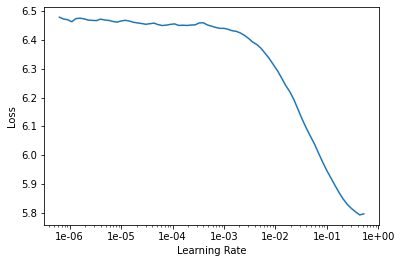

In [22]:
learn.recorder.plot(skip_end=15)

In [23]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.331801,4.663113,0.184375,00:05


In [24]:
learn.save('fit_head')

In [21]:
learn.load('fit_head');

RuntimeError: ignored

In [26]:
learn.unfreeze()

In [27]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7),)

epoch,train_loss,valid_loss,accuracy,time
0,4.589214,4.420666,0.224926,00:06
1,4.404024,4.192825,0.255134,00:06
2,4.156201,3.997460,0.284598,00:06
3,3.817023,3.839718,0.314211,00:06
4,3.450453,3.752278,0.339509,00:06
5,3.058727,3.712267,0.355432,00:06
6,2.697899,3.717963,0.363839,00:06
7,2.411903,3.734269,0.368527,00:06
8,2.218058,3.739888,0.370982,00:07
9,2.079492,3.745901,0.370387,00:07


In [28]:
learn.save('fine_tuned')

In [ ]:
learn.load('fine_tuned');


In [23]:
TEXT = "hi there"
N_WORDS = 40
N_SENTENCES = 2

In [24]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

hi there 's First Class ( The Office ) = a " Family Road " is a song by American American Music Academy , American Academy Music Video
hi there a Boy Like Me ( film ) = a Boy Is Gone is a film about the lives of the European High School Football Team and the Academy


In [25]:
learn.save_encoder('fine_tuned_enc')

In [26]:
dat = pd.read_csv("/content/drive/My Drive/data/texts.csv")
dat

,labels,text
0,0,its their character not their color that matters
1,0,don't be afraid to love again everyone is not ...
2,0,putting bows on your pet
3,0,i love everything and everybody! except for sq...
4,0,"everybody loves chocolate chip cookies, even h..."
...,...,...
8495,1,nobody wants to hang auschwitz me
8496,1,when god grants you a child after 20 years of ...
8497,1,gays on social media: equality! body positivit...
8498,1,having a bad day? you could be a siamese twin ...


In [27]:
data_clas = (TextList.from_csv(path="/content/drive/My Drive/data/",csv_name="texts.csv", vocab=data_lm.vocab,cols=1)
             #grab all the text files in path
             .split_by_rand_pct(0.2)
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_df(cols=0)
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

In [28]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [29]:
data_clas.show_batch(10)

text,target
"xxbos housing , free gas , free xxunk , free healthcare and free education for my wives and children . to show xxunk for your xxunk , i 'll xxunk your 12 year old daughters , blow up your xxunk , xxunk and buses and xxunk hate through a xxunk xxunk in your local city and town xxunk with the purpose of xxunk your xxunk country into the same shithole",1
"xxbos "" nobody is trying to take your guns ! "" "" we only want to make you xxunk them , xxunk xxunk , ban xxunk guns , xxunk magazine xxunk , xxunk xxunk them , ban or xxunk ammo , make other xxunk laws , and , if we catch you xxunk any of these made - up rules , throw you in prison xxrep 4 . at which",0
xxbos xxunk you killed me so the jew could control your media so the jews could control your banks so the jews control you money so the jews could control your government so your children could die for israel so foreigners could destroy your cities so foreigners could run your civil and public services so you become a xxunk in your own xxunk so your people and race are lost,1
"xxbos my xxunk for the suffering in xxunk does not make me anti - semitic , xxunk does it make me pro - xxunk or anti - israel . it makes me human it makes you a xxunk xxunk for xxunk and xxunk terrorists ! if you do n't see that , .. it makes you stupid !",0
"xxbos in xxunk , the xxunk xxunk willie xxunk 's bank xxunk and real estate xxunk for a 16 million dollar tax xxunk . xxunk , al xxunk owes in xxunk of 19 million dollars in taxes and he xxunk the white house xxunk as a xxunk ! ! ! explain white xxunk again ?",0
"xxbos in 2014 , i helped put together and xxunk a $ 25 billion dollar deal to xxunk a border wall . now , trump wants $ 5 billion for a border wall well i 'm gon na bitch , cry , piss and xxunk just because he 's a republican and wants it",0
"xxbos what is he hiding ? we need to see his tax returns ! let me stop you right there hillary you deleted 30,000 emails , used bleach bit on hard drives , then destroyed phones with hammers you have no right to talk about people hiding anything truth xxunk",0
"xxbos how sad it must be for supporters - xxunk that scientist , xxunk , xxunk , xxunk , and xxunk have xxunk their entire lives to xxunk america , while a reality - tv star with decades of fraud and xxunk - xxunk lying is your xxunk of xxunk",0
xxbos i will lie . i will sleep with anyone . i will attack sexual perverts like joe biden in my own party to get ahead ! i will let illegals murder americans . i will let xxunk be i want to be your comfortable and executed president !,1
"xxbos what is he hiding ? we need to see his tax returns ! let me stop you right there hillary you deleted 30,000 emails , used bleach bit on hard drives then destroyed phones with hammers you have no right to talk about people hiding anything truth xxunk",0


In [30]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (6800 items)
x: TextList
xxbos its their character not their color that matters,xxbos do n't be afraid to love again everyone is not like your ex,xxbos i love everything and everybody ! except for xxunk i hate xxunk,xxbos everybody loves chocolate xxunk cookies , even hitler,xxbos fine you 're right . now can we fucking drop it ?
y: CategoryList
0,0,0,0,0
Path: /content/drive/My Drive/data;

Valid: LabelList (1700 items)
x: TextList
xxbos me getting offended at a joke is like a jew escaping a gas chamber it never happens,xxbos xxunk police xxunk a new weapon to fight xxunk gang,xxbos when you xxunk area 51 to find aliens but all you find are mexicans,xxbos about to explode l with pride now that his daughter can go to school,xxbos now that the russia collusion myth is over are you ready for the xxunk punch ?
y: CategoryList
1,0,1,0,0
Path: /content/drive/My Drive/data;

Test: None, model=SequentialRNN(
  (0): MultiBatchEncoder(
    (m

In [38]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


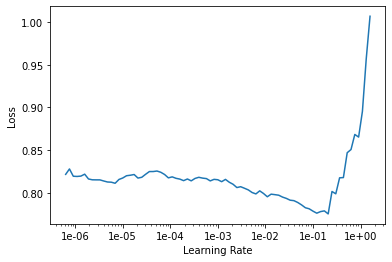

In [39]:
learn.recorder.plot()

In [40]:
learn.fit_one_cycle(10, slice(1e-3, 1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.703717,0.641596,0.638235,00:04
1,0.645924,0.630265,0.649412,00:04
2,0.637724,0.614416,0.669412,00:04
3,0.623292,0.617842,0.647059,00:04
4,0.617747,0.615377,0.660000,00:04
5,0.613887,0.610058,0.680588,00:04
6,0.600215,0.607786,0.675882,00:04
7,0.592039,0.610348,0.674118,00:04
8,0.587874,0.608108,0.677059,00:04
9,0.588280,0.605816,0.675294,00:04


In [31]:
learn.predict(" kill girls")

(Category tensor(0), tensor(0), tensor([0.5355, 0.4645]))

In [32]:
learn.save('first')

In [58]:
learn.load('first');

f = jsonlines.open('/content/drive/My Drive/data/test.jsonl',)
data=[]
with jsonlines.open('/content/drive/My Drive/data/test.jsonl') as reader:
    for obj in reader:
        data.append(obj['text'])


In [59]:
test = DataFrame()

test["text"]=data

test

,text
0,handjobs sold seperately
1,introducing fidget spinner for women
2,happy pride month let's go beat up lesbians
3,laughs in [majority of u.s crime rate]
4,finds out those 72 virgins.. are goats
...,...
995,a mother's love for the child is a divine thing
996,sea monkeys
997,little miss muffet sat on her tuffet
998,they're in a row


In [60]:
y = learn.predict(test.iloc[0])
print(y)
y=list(y[2])
y = float(y[1])
y

(Category tensor(0), tensor(0), tensor([0.5347, 0.4653]))


0.46525418758392334

In [61]:
ans = []
ans_float = []
for i in range (0,1000):
    y = learn.predict(test.iloc[i])
    y = list(y[2])
    p1 = float(y[0])
    p2 = float(y[1])
    if p1>p2:
      ans.append(0)
      ans_float.append(p1)
    else:
      ans.append(1)
      ans_float.append(p2)


In [62]:
sub = pd.read_csv("/content/submission_format.csv")

In [65]:
sub

,id,proba,label
0,16395,0.534746,0
1,37405,0.517914,0
2,94180,0.506293,1
3,54321,0.525031,0
4,97015,0.531079,0
...,...,...,...
995,3869,0.522407,0
996,23817,0.535380,0
997,56280,0.536291,0
998,29384,0.528796,0


In [64]:
sub["label"] = ans
sub["proba"] = ans_float

In [67]:
sub.to_csv("/content/final_submission", index=False)
